## Pre-Requisites

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install git+https://github.com/fbcotter/pytorch_wavelets

  Cloning https://github.com/fbcotter/pytorch_wavelets to /tmp/pip-req-build-iklifj9r
  Running command git clone --filter=blob:none --quiet https://github.com/fbcotter/pytorch_wavelets /tmp/pip-req-build-iklifj9r
  Resolved https://github.com/fbcotter/pytorch_wavelets to commit 9a0c507f04f43c5397e384bb6be8340169b2fd9a
  Preparing metadata (setup.py) ... done


In [ ]:
pip install hyde-images

## Import Dependencies

In [ ]:
import numpy as np
import hyde
import torch
import cv2
import PIL
from PIL import Image as im

def tensorToImageConversion(Tensor):
    Tensor = np.array(Tensor, dtype=np.uint8)
    if np.ndim(Tensor)>3:
        assert Tensor.shape[0] == 1
        Tensor = Tensor[0]
    return PIL.Image.fromarray(Tensor)

directory = '/content/drive/MyDrive/RGamma/M3G20090606T093322_V01_L2_8.tif'
input = cv2.imread(directory)
input_tens = torch.tensor(input, dtype=torch.float32)

## [`HyMiNoR`](https://doi.org/10.1109/LGRS.2019.2924344) Overview

1.   **Initialization**: The process begins by initializing the hyperspectral image $H$ and the hyperspectral restoration result $\hat{Y}$ obtained using the HyRes technique, which estimates the noise-free signal $Y$.

2.   **Formulating the Optimization Problem**: The objective is to find the noise-free image $X$ that best represents the observed hyperspectral image while being sparse. The optimization problem is formulated as follows:
\begin{equation}
J(X) = \min_X \|\hat{Y} - X\|_1 + \lambda \|DX\|_1
\end{equation}
where:
  - $J(X)$ is the cost function representing the objective to be minimized.
  - $X$ is the unknown noise-free image that needs to be estimated.
  - $\hat{Y}$ is the estimated noise-free signal obtained from the hyperspectral restoration step (HyRes).
  - $DX$ is the first-order difference matrix applied to $X$ to exploit the high spectral correlation of the hyperspectral image.
  - $\|\cdot\|_1$ denotes the $1$-norm of a vector, which is the sum of the absolute values of its elements.
  - $\lambda$ is a tuning parameter that controls the trade-off between enforcing sparsity (removing sparse noise) and the fidelity to the estimated signal $\hat{Y}$.

3.   **Solving the Optimization Problem**: The optimization problem is solved using the split Bregman technique, which is an iterative algorithm. It updates the noise-free image $X$ and auxiliary variables $V1$ and $V2$ in a step-by-step manner while keeping other variables constant.

4.   **X-Step**: Given fixed $V1$ and $V2$, the optimization problem becomes a least-squares problem, which can be efficiently solved. The noise-free image $X$ is updated using the following equation:
\begin{equation}
X_{m+1} = \Lambda^{-1} \left[-\mu_1(V1 - \hat{Y} - L1) + \mu_2 D^T (V2 - L2)\right]
\end{equation}
where $\Lambda$ is a diagonal matrix, and $\mu_1$ and $\mu_2$ are penalty parameters.

5.   **V1-Step**: Given fixed $X_{m+1}$ and $V2$, $V1$ is updated using the soft-thresholding operator:
\begin{equation}
V_{m+1,1} = \text{soft}\left(\hat{Y} - X_{m+1} + L1, \mu_1\right)
\end{equation}

6.   **V2-Step**: Given fixed $X_{m+1}$ and $V1$, $V2$ is updated using the soft-thresholding operator:
\begin{equation}
V_{m+1,2} = \text{soft}\left(DX_{m+1} + L2, \frac{\lambda}{\mu_2}\right)
\end{equation}

7.   **Updating Lagrange Multipliers**: The Lagrange multipliers $L1$ and $L2$ are updated in each iteration:
\begin{equation}
L1 = L1 + \hat{Y} - X - V1
\end{equation}
\begin{equation}
L2 = L2 + DX - V2
\end{equation}
8.   **Iterative Process**: Steps 4 to 7 are iteratively performed until convergence, which is determined by a predefined tolerance value.
9.   **Final Result**: After convergence, the noise-free image $X$ is obtained, with sparse noise effectively removed, and it represents the denoised hyperspectral image.

## [`HyMiNoR`](https://doi.org/10.1109/LGRS.2019.2924344) Implementation

https://colab.research.google.com/drive/1-4-hMmyj54_ABgygpY1LNpEsxHNhpmAL?usp=sharing

```
import torch

from hyde.lowlevel import utils

from .hyres import HyRes

__all__ = ["HyMiNoR"]


class HyMiNoR(torch.nn.Module):
    """
    HyMiNoR -- Hyperspectral Mixed Gaussian and Sparse Noise Reduction

    This is a two step mixed nose removal technique for hypersperctral images which was presented
    in [1] The two steps are:

        1. The Gaussian noise is removed using :func:`HyRes <hyde.hyres.HyRes>`
        2. The sparse noised is solved as: :math:`\min\limits_{X} ||H-X||_1+ \lambda ||X*D'||_1` where :math:`D` is the difference matrix.

    The data used should be normalized to range from 0 to 1.

    Parameters
    ----------
    decomp_level : int, optional
        the level of the wavelet decomposition to do
        default: 5
    wavelet_level : int, optional
        the integer value indicating which Daubechies wavelet to use. i.e. 5 -> db5
        default: 5
    padding_method : str, optional
        the method used to pad the image during the DWT transform.
        options: [zero, symmetric, periodization, reflect, periodic]
        default: "symmetric"

    Notes
    -----
    Algorithmic questions should be forwarded to the original authors. This is purely an
    implementation of the algorithm detailed in [1].

    References
    ----------
    [1] B. Rasti, P. Ghamisi and J. A. Benediktsson, "Hyperspectral Mixed Gaussian and Sparse Noise Reduction," in IEEE Geoscience and Remote Sensing Letters, vol. 17, no. 3, pp. 474-478, March 2020, doi: 10.1109/LGRS.2019.2924344.
    """

    def __init__(self, decomp_level=5, wavelet_level=5, padding_method="symmetric"):
        super(HyMiNoR, self).__init__()
        self.hyres = HyRes(
            decomp_level=decomp_level,
            wavelet_level=wavelet_level,
            padding_method=padding_method,
        )

    def forward(self, x: torch.Tensor, lam: float = 10.0, iterations: int = 50):
        """
        Do the HyMiNoR decomposition.

        Parameters
        ----------
        x : torch.Tensor
            the image/array to be de-noised
        lam : float, optional
            the tuning parameter
            default: 10.
        iterations : int, optional
            the number of iterations to do
            default: 50

        Returns
        -------
        denoised image : torch.Tensor
        """
        base_dtype = x.dtype
        # H_M -> x ; lambda -> lam
        mu1, mu2, its = 0.5, 0.5, iterations
        # H=HyRes(H_M);
        hyres_result = self.hyres.forward(x)

        m, n, d = hyres_result.shape
        # [m,n,d]=size(H);
        mn = m * n
        # Y=reshape(H,mn,d)';
        hyres_reshaped_t = torch.conj(hyres_result.reshape((mn, d))).T
        l1 = torch.zeros((d, mn), device=x.device, dtype=x.dtype)
        l2 = torch.zeros((d, mn), device=x.device, dtype=x.dtype)
        v1 = torch.zeros((d, mn), device=x.device, dtype=x.dtype)
        v2 = torch.zeros((d, mn), device=x.device, dtype=x.dtype)
        xx = torch.zeros((d, mn), device=x.device, dtype=x.dtype)
        # X=L1;
        eye_d = torch.eye(d, device=x.device, dtype=x.dtype)
        hold = utils.diff_dim0_replace_last_row(utils.diff(eye_d))
        u, s, v = torch.linalg.svd(hold.to(torch.float64), full_matrices=False)
        v = torch.conj(v.T)

        magic = (v @ torch.diag(1.0 / (mu1 + mu2 * s)) @ torch.conj(u.T)).to(base_dtype)

        for i in range(its):
            # subminimization problems
            hold1 = -mu1 * (v1 - hyres_reshaped_t - l1)
            hold2 = mu2 * utils.diff_dim0_replace_last_row(v2 - l2)
            # X=Majic*(-mu1*(V1-Y-L1)+mu2*Dvt(V2-L2));
            xx = magic @ (hold1 + hold2)

            v1 = utils.soft_threshold(hyres_reshaped_t - xx + l1, 1.0 / mu1)
            dv_xx = utils.diff(xx)
            v2 = utils.soft_threshold(dv_xx + l2, float(lam) / mu2)
            # Updating L1 and L2
            l1 += hyres_reshaped_t - xx - v1
            l2 += dv_xx - v2

        ret = torch.reshape(xx.T, (m, n, d))
        return ret

```


In [ ]:
mix = hyde.HyMiNoR()
output = mix(input_tens)

## O/P HSI

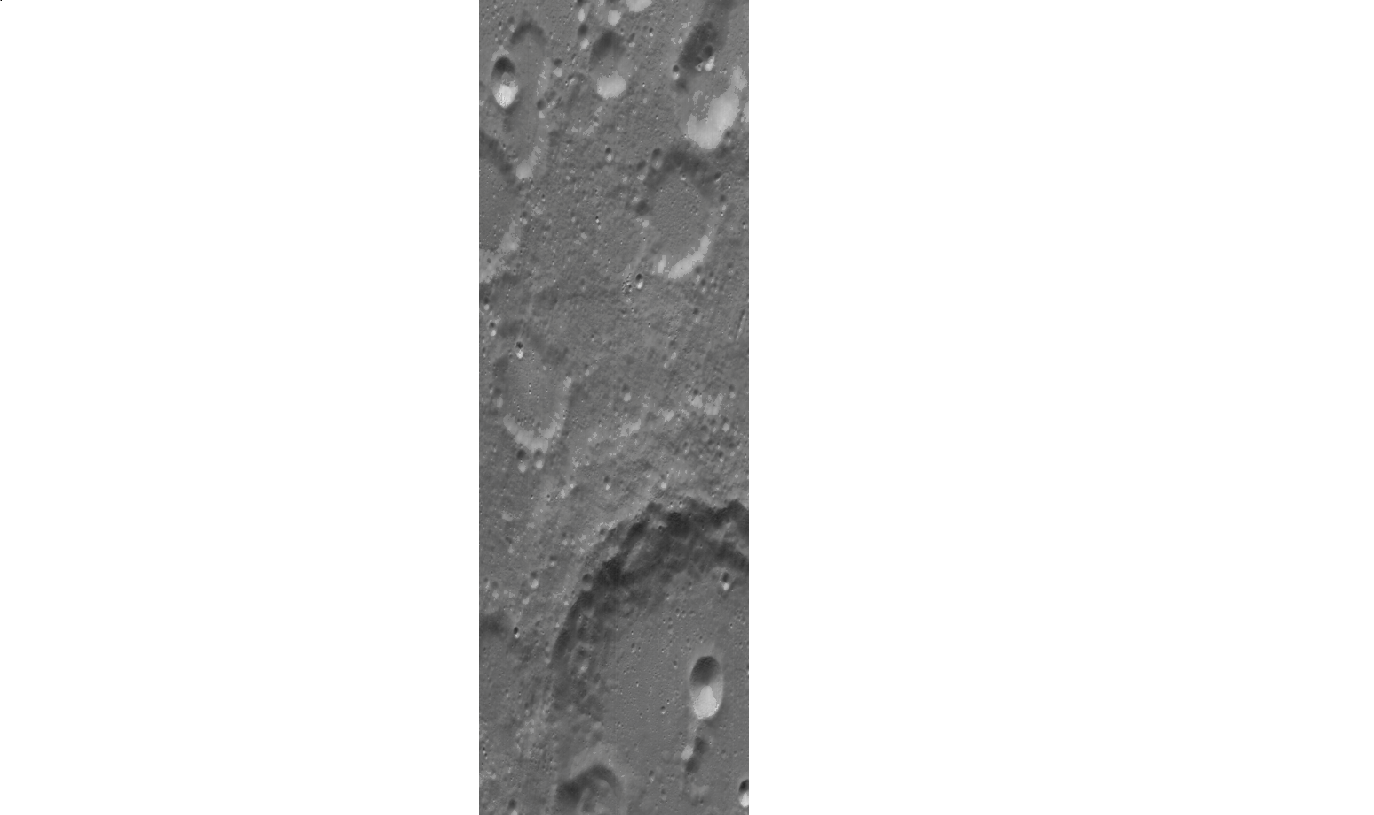

In [ ]:
tensorToImageConversion(output)